# Approach1: Fixed grid size chunking

1. Pad the orignal image to make multiple of 640.
2. Generate chunks of fix grid size 640 x 640.
3. Consider overlap of 100 px with stride 540px. 
4. Compute bbox predictions per chunk. 
5. Map back the predictions to orignal image.
6. Compute NMS to generate final predictions.

In [37]:
images_list = [
    "100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8.jpg",
    # "conference-hall-1_png_jpg.rf.7914f207e0281cc9075b6aeb62577d35.jpg",
    # "1000_F_401528233_VSmYHU4egULupOxhR9NVLUL1V4KFVVsr_jpg.rf.0edff936e786658819fc0e7b5e28b633.jpg",
    # "50T_plan_page-0001_jpg.rf.acf491527423431a79e3506dc13a8ac9.jpg",
]

In [38]:
images_list

['100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8.jpg']

In [39]:
import os
import json
import cv2
import numpy as np
from pathlib import Path

# CHUNK CONFIG
CHUNK_SIZE = 640
OVERLAP = 100
STRIDE = CHUNK_SIZE - OVERLAP

# DIRECTORIES
# INPUT_JSON = '/home/vatsal/Downloads/All_dataset/roboflow_cluster_annotations/test/test.json'
INPUT_IMAGE_DIR = '/home/vatsal/Downloads/All_dataset/Chair Table Floor Plan Detection.v14i.coco/test' \
# INPUT_IMAGE_DIR = '/home/vatsal/Documents/Inference_images'      
OUTPUT_ROOT = Path('./output/')
# COLOR_DIR = OUTPUT_ROOT / 'color'
GRAY_DIR = OUTPUT_ROOT / 'gray'
# MS_OUTPUT_ROOT = Path('./multiscale_images/')
# MS_COLOR_DIR = MS_OUTPUT_ROOT / 'color'
# MS_GRAY_DIR = MS_OUTPUT_ROOT / 'gray'

# CREATE OUTPUT DIRS
OUTPUT_ROOT.mkdir(exist_ok=True)
# COLOR_DIR.mkdir(parents=True, exist_ok=True)
GRAY_DIR.mkdir(parents=True, exist_ok=True)
# MS_OUTPUT_ROOT.mkdir(exist_ok=True)
# MS_COLOR_DIR.mkdir(parents=True, exist_ok=True)
# MS_GRAY_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
# # Load the annotation json file
# with open(INPUT_JSON, 'r') as f:
#     coco_data = json.load(f)

# # Extract the annotations for the 5 images in the image list
# selected_images = [
#     img for img in coco_data['images']
#     if img['file_name'] in images_list
# ]

# # Extract image ids for the 5 images
# selected_image_ids = set(img['id'] for img in selected_images)

# # Extract annotations for the 5 images using image ids
# selected_annotations = [
#     ann for ann in coco_data['annotations']
#     if ann['image_id'] in selected_image_ids
# ]

# # Extract the categories from the json file
# categories = coco_data['categories']

# # Create maooing of image id and orignal image names
# image_id_to_filename = {img['id']: img['file_name'] for img in selected_images}

# from collections import defaultdict
# ann_by_image = defaultdict(list)
# for ann in selected_annotations:
#     ann_by_image[ann['image_id']].append(ann)


In [92]:
5//2


2

In [5]:
def pad_images(image):
    """
    Add padding to make the image symmetric. 
    Pad the image to make it multiple of 640 to simplify chunking.
    """
    h, w = image.shape[:2]
    new_h = ((h + CHUNK_SIZE - 1) // CHUNK_SIZE) * CHUNK_SIZE
    new_w = ((w + CHUNK_SIZE - 1) // CHUNK_SIZE) * CHUNK_SIZE
    pad_bottom = new_h - h
    pad_right = new_w - w

    padded_image = cv2.copyMakeBorder(
        image, 0, pad_bottom, 0, pad_right, cv2.BORDER_CONSTANT, value=(255, 255, 255)
    )
    return padded_image, (w, h), (new_w, new_h)

# visualize the padded_image
for filename in images_list:
    image_path = os.path.join(INPUT_IMAGE_DIR, filename)
    original = cv2.imread(image_path)
    padded_image, original_shape, padded_shape = pad_images(original)
    print(f"Original shape: {original_shape}, Padded shape: {padded_shape}")
    print(len(padded_image))


Original shape: (1782, 2553), Padded shape: (1920, 2560)
2560


In [11]:
def generate_chunks(padded_image):
    """
    Generate chunks of 640 x 640 with stride of 540 to create an 
    overlap of 100px to the right and bottom of the image.
    """

    h, w = padded_image.shape[:2]

    y_coords = list(range(0, h - CHUNK_SIZE + 1, STRIDE))
    if y_coords[-1] + CHUNK_SIZE < h:
        y_coords.append(h - CHUNK_SIZE)  # force last row

    x_coords = list(range(0, w - CHUNK_SIZE + 1, STRIDE))
    if x_coords[-1] + CHUNK_SIZE < w:
        x_coords.append(w - CHUNK_SIZE)  # force last column

    for y in y_coords:
        for x in x_coords:
            chunk = padded_image[y:y + CHUNK_SIZE, x:x + CHUNK_SIZE]
            yield chunk, (x, y)

In [ ]:
# def generate_chunks(padded_image):
#     """
#     Generate chunks of 640 x 640 with stride of 540 to create an 
#     overlap of 100px to the right and bottom of the image.
#     """

#     h, w = padded_image.shape[:2]
#     for y in range(0, h - CHUNK_SIZE + 1, STRIDE):
#         for x in range(0, w - CHUNK_SIZE + 1, STRIDE):
#             chunk = padded_image[y:y + CHUNK_SIZE, x:x + CHUNK_SIZE]
#             yield chunk, (x, y)


In [6]:
def get_chunk_annotations(global_anns, chunk_origin):
    """
    Scale the ground truth annotations based on the chunk size.
    """

    # Extract chunk boundaries 
    chunk_x_min, chunk_y_min = chunk_origin
    chunk_x_max, chunk_y_max = chunk_x_min + CHUNK_SIZE, chunk_y_min + CHUNK_SIZE
    chunk_boxes = []

    for ann in global_anns:

        # Annotations format [x_min, y_min, width, height]
        box_x_min, box_y_min, box_w, box_h = ann['bbox']
        
        # Calculate the x_max of the bbox
        box_x_max = box_x_min + box_w

        # Calculate the y_max of the bbox
        box_y_max = box_y_min + box_h

        # Accept only fully-contained bboxes
        if (box_x_min >= chunk_x_min and box_x_max <= chunk_x_max and
            box_y_min >= chunk_y_min and box_y_max <= chunk_y_max):

            # Convert to chunk-local coordinates
            local_x = box_x_min - chunk_x_min
            local_y = box_y_min - chunk_y_min
            local_box = [local_x, local_y, box_w, box_h]

            chunk_boxes.append((ann['category_id'], local_box))

    return chunk_boxes


## Generate separate dastset for 5 chunked images with annotations.

In [43]:
# Load the orignal image
for filename in images_list:
    image_path = os.path.join(INPUT_IMAGE_DIR, filename)
    original = cv2.imread(image_path)
    print(f"Processing image: {filename} with shape {original.shape}")

    # Add padding to generate a symmetric image. 
    padded, _, _ = pad_images(original)
    print(f"Padded image shape: {padded.shape}")

    for chunk, (cx, cy) in generate_chunks(padded):
        # print(f"Processing chunk at ({cx}, {cy}) with shape {chunk.shape}")
        # Save color version
        chunk_filename = f"{Path(filename).stem}_x{cx}_y{cy}.jpg"
        # color_path = COLOR_DIR / chunk_filename
        gray_chunk = cv2.cvtColor(chunk, cv2.COLOR_BGR2GRAY)
        gray_path = GRAY_DIR / chunk_filename
        cv2.imwrite(str(gray_path), gray_chunk)


Processing image: 100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8.jpg with shape (2577, 2681, 3)
Padded image shape: (3200, 3200, 3)


In [ ]:
chunk_image_id = 1
chunk_ann_id = 1

# # Annotation file format for the chunks
# coco_chunks = {
#     "images": [],
#     "annotations": [],
#     "categories": categories
# }


for image_id, filename in image_id_to_filename.items():

    # Load the orignal image
    image_path = os.path.join(INPUT_IMAGE_DIR, filename)
    original = cv2.imread(image_path)

    # Add padding to generate a symmetric image. 
    padded, _, _ = pad_images(original)
    # anns = ann_by_image[image_id]

    for chunk, (cx, cy) in generate_chunks(padded):
        # Save color version
        chunk_filename = f"{Path(filename).stem}_x{cx}_y{cy}.jpg"
        # color_path = COLOR_DIR / chunk_filename
        gray_path = GRAY_DIR / chunk_filename

        cv2.imwrite(str(color_path), chunk)

        # Save grayscale version
        gray_chunk = cv2.cvtColor(chunk, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(str(gray_path), gray_chunk)

        # # Add to COCO images
        # coco_chunks["images"].append({
        #     "id": chunk_image_id,
        #     "file_name": chunk_filename,
        #     "width": CHUNK_SIZE,
        #     "height": CHUNK_SIZE,
        #     "source_image": filename,
        #     "offset": [cx, cy]
        # })

        # # Match bboxes for this chunk
        # local_anns = get_chunk_annotations(anns, (cx, cy))
        # for cat_id, bbox in local_anns:
        #     area = bbox[2] * bbox[3]
        #     coco_chunks["annotations"].append({
        #         "id": chunk_ann_id,
        #         "image_id": chunk_image_id,
        #         "category_id": cat_id,
        #         "bbox": bbox,
        #         "area": area,
        #         "iscrowd": 0
        #     })
        #     chunk_ann_id += 1

        chunk_image_id += 1


In [ ]:
with open(OUTPUT_ROOT / 'annotations.json', 'w') as f:
    json.dump(coco_chunks, f, indent=2)

## Perform inferencing on the fine tuned model

In [44]:
# chunk_list = os.listdir("/home/vatsal/Documents/analysis/sample_images")
chunk_list = os.listdir(GRAY_DIR)

# chunks_list = [
#     # "/home/harsh/Projects/Upflix/temp/output/gray/conference-hall-1_png_jpg.rf.7914f207e0281cc9075b6aeb62577d35_x0_y0.jpg",
#     # "/home/harsh/Projects/Upflix/temp/output/gray/conference-hall-1_png_jpg.rf.7914f207e0281cc9075b6aeb62577d35_x0_y490.jpg",
#     # "/home/harsh/Projects/Upflix/temp/output/gray/conference-hall-1_png_jpg.rf.7914f207e0281cc9075b6aeb62577d35_x0_y980.jpg",
#     # "/home/harsh/Projects/Upflix/temp/output/gray/conference-hall-1_png_jpg.rf.7914f207e0281cc9075b6aeb62577d35_x490_y0.jpg",
#     # "/home/harsh/Projects/Upflix/temp/output/gray/conference-hall-1_png_jpg.rf.7914f207e0281cc9075b6aeb62577d35_x490_y490.jpg",
#     # "/home/harsh/Projects/Upflix/temp/output/gray/conference-hall-1_png_jpg.rf.7914f207e0281cc9075b6aeb62577d35_x490_y980.jpg",
#     "/home/harsh/Projects/Upflix/temp/output/gray/conference-hall-1_png_jpg.rf.7914f207e0281cc9075b6aeb62577d35_x980_y0.jpg",
#     "/home/harsh/Projects/Upflix/temp/output/gray/conference-hall-1_png_jpg.rf.7914f207e0281cc9075b6aeb62577d35_x980_y490.jpg",
#     "/home/harsh/Projects/Upflix/temp/output/gray/conference-hall-1_png_jpg.rf.7914f207e0281cc9075b6aeb62577d35_x980_y980.jpg",
#     "/home/harsh/Projects/Upflix/temp/output/gray/conference-hall-1_png_jpg.rf.7914f207e0281cc9075b6aeb62577d35_x1470_y0.jpg",
#     "/home/harsh/Projects/Upflix/temp/output/gray/conference-hall-1_png_jpg.rf.7914f207e0281cc9075b6aeb62577d35_x1470_y490.jpg",
#     "/home/harsh/Projects/Upflix/temp/output/gray/conference-hall-1_png_jpg.rf.7914f207e0281cc9075b6aeb62577d35_x1470_y980.jpg"
# ]

In [45]:
chunk_list

['100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8_x2160_y1080.jpg',
 '100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8_x0_y540.jpg',
 '100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8_x0_y1080.jpg',
 '100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8_x540_y540.jpg',
 '100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8_x540_y1620.jpg',
 '100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8_x1620_y2160.jpg',
 '100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8_x540_y1080.jpg',
 '100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8_x2160_y1620.jpg',
 '100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8_x2160_y2560.jpg',
 '100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8_x0_y2560.jpg',
 '100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8_x1080_y1080.jpg',
 '100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8_x540_y2560.jpg',
 '100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f

In [76]:
for image in chunk_list:
    image_path = Path(image)
    image_name = image_path.stem
    print(image_path)

100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8_x2450_y980.jpg
100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8_x2450_y490.jpg


In [82]:
from inference import get_model
import supervision as sv
import cv2
import json
from pathlib import Path

# load the fine-tuned model
model = get_model(model_id="floorplan-o9hev/6", api_key="LLDV1nzXicfTYmlj9CMp")
image_dir = Path("/home/vatsal/Documents/output1/chunk_predictions_2/images")



for image in chunk_list:
    image_path = Path(image)
    # image_
    image_name = image_path.stem
    image = cv2.imread(os.path.join("/home/vatsal/Documents/analysis/sample_images", image_path))
    # image = cv2.imread(str(GRAY_DIR / image_path))
    height, width = image.shape[:2]

    # run inference on our chosen image, image can be a url, a numpy array, a PIL image, etc.
    results = model.infer(image)[0]   # returns 

In [46]:
from inference import get_model
import supervision as sv
import cv2
import json
from pathlib import Path

# load the fine-tuned model
model = get_model(model_id="floorplan-o9hev/6", api_key="LLDV1nzXicfTYmlj9CMp")
image_dir = Path("/home/vatsal/Documents/output1/chunk_predictions_2/images")


for image in chunk_list:
    image_path = Path(image)
    # image_
    image_name = image_path.stem
    # image = cv2.imread(os.path.join("/home/vatsal/Documents/analysis/sample_images", image_path))
    image = cv2.imread(str(GRAY_DIR / image_path))
    height, width = image.shape[:2]

    # run inference on our chosen image, image can be a url, a numpy array, a PIL image, etc.
    results = model.infer(image)[0]   # returns 

    # load the results into the supervision Detections api
    allowed_classes = ["table", "chair", "table-chair"]

    detections = sv.Detections.from_inference(results)

    # create supervision annotators
    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    # annotate the image with our inference results
    annotated_image = bounding_box_annotator.annotate(
        scene=image, detections=detections)
    annotated_image = label_annotator.annotate(
        scene=annotated_image, detections=detections)

    annotated_path = image_dir / f"{image_name}.jpg"
    cv2.imwrite(str(annotated_path), annotated_image)

    # Prepare COCO-style JSON
    image_entry = {
        "id": 1,
        "file_name": image_path.name,
        "width": width,
        "height": height
    }

    annotations = []
    for ann_id, i in enumerate(range(len(detections.xyxy)), start=1):
        x_min, y_min, x_max, y_max = detections.xyxy[i]
        width_bbox = x_max - x_min
        height_bbox = y_max - y_min
        area = width_bbox * height_bbox
        class_id = detections.class_id[i]
        confidence = float(detections.confidence[i])
        label = detections.data['class_name'][i] if 'class_name' in detections.data else str(class_id)
        if label not in allowed_classes:
            continue
        category_id = {
            "chair": 100,
            "table": 101,
            "table-chair": 103
        }.get(label.lower(), 999)  # Default 999 for unknown

        annotations.append({
            "id": ann_id,
            "image_id": 1,
            "category_id": category_id,
            "bbox": [float(x_min), float(y_min), float(width_bbox), float(height_bbox)],
            "area": float(area),
            "iscrowd": 0
        })

    # Final JSON output in COCO format
    coco_json = {
        "info": {
            "year": "2024",
            "version": "14",
            "description": "Exported from roboflow.com",
            "contributor": "",
            "url": "https://public.roboflow.com/object-detection/undefined",
            "date_created": "2024-11-25T04:08:53+00:00"
        },
        "licenses": [
            {
                "id": 1,
                "url": "https://creativecommons.org/licenses/by/4.0/",
                "name": "CC BY 4.0"
            }
        ],
        "categories": [
            { "id": 100, "name": "chair" },
            { "id": 101, "name": "table" },
            { "id": 103, "name": "table-chair" }
        ],
        "image": [image_entry],
        "annotations": annotations
    }

    # Save to file
    output_json_path = Path("/home/vatsal/Documents/output1/chunk_predictions_2/json_1") / f"{image_name}.json"
    output_json_path.parent.mkdir(parents=True, exist_ok=True)
    with open(output_json_path, "w") as f:
        json.dump(coco_json, f, indent=4)

print(f"✅ Saved Chunk json files")


✅ Saved Chunk json files


In [98]:
import os
import json

# Setup
json_dir_path = "/home/vatsal/Documents/output1/chunk_predictions_2/json"
allowed_classes = {"chair", "table", "table-chair"}

chair_count = 0
table_count = 0
table_chair_count = 0
total_count = 0
skipped_count = 0

# Loop through all JSON files
for file in os.listdir(json_dir_path):
    if not file.endswith(".json"):
        continue

    with open(os.path.join(json_dir_path, file), "r") as f:
        data = json.load(f)

    annotations = data.get("annotations", [])
    for ann in annotations:
        category_id = ann["category_id"]
        if category_id == 100:
            chair_count += 1
        elif category_id == 101:
            table_count += 1
        elif category_id == 103:
            table_chair_count += 1
        else:
            skipped_count += 1
        total_count += 1

# Final summary
print(f"✅ Chunk Prediction Summary")
print(f"Total chair count       : {chair_count}")
print(f"Total table count       : {table_count}")
print(f"Total table-chair count : {table_chair_count}")
print(f"Total skipped count     : {skipped_count}")
print(f"Total annotations       : {total_count}")


✅ Chunk Prediction Summary
Total chair count       : 120
Total table count       : 19
Total table-chair count : 13
Total skipped count     : 0
Total annotations       : 152


In [47]:
import os
import json
import re
from collections import defaultdict

def load_chunk_predictions(predictions_dir, original_sizes, image_name_to_id,):
    
    all_chunk_preds = []

    for file in os.listdir(predictions_dir):
        if not file.endswith(".json"):
            continue

        file_path = os.path.join(predictions_dir, file)
        with open(file_path, 'r') as f:
            chunk_data = json.load(f)

        categories_map = {cat['name']: cat['id'] for cat in chunk_data['categories']}
        chunk_image = chunk_data['image'][0]
        chunk_path = chunk_image['file_name']
        annotations = chunk_data['annotations']

        # Extract image name and chunk_x, chunk_y from filename
        filename = os.path.basename(chunk_path)

        # Expected format: abc_xyz.jpg.rf.xxx_x0_y0.jpg → extract x0 and y0
        match = re.search(r'_x(\d+)_y(\d+)\.jpg', filename)
        if not match:
            print(f"Filename parse failed for {filename}")
            continue

        chunk_x = int(match.group(1))
        chunk_y = int(match.group(2))

        # Get original image name
        original_image_name = filename.split('_x')[0] + '.jpg'
        image_id = image_name_to_id[original_image_name]
        original_size = original_sizes[original_image_name]

        preds = []
        for ann in annotations:
            x1, y1, w, h = ann['bbox']
            cls_id = ann['category_id']
            preds.append([x1, y1, w, h, cls_id])

        all_chunk_preds.append(((chunk_x, chunk_y), preds, original_size, image_id))

    return all_chunk_preds


In [48]:
# These must be available from your COCO dataset:
# image_name_to_id = {img['file_name']: img['id'] for img in coco_data['images']}
# original_sizes = {img['file_name']: (img['width'], img['height']) for img in coco_data['images']}
# categories_map = {cat['name']: cat['id'] for cat in coco_data['categories']}

image_name_to_id = {"100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8.jpg": 1}
original_sizes = {"100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8.jpg": (2681, 2577)}

pred_dir = "/home/vatsal/Documents/output1/chunk_predictions_2/json_1"
all_chunk_preds = load_chunk_predictions(pred_dir, original_sizes, image_name_to_id)


In [49]:
all_chunk_preds

[((1620, 1080),
  [[430.2743225097656,
    332.24298095703125,
    80.01516723632812,
    63.313812255859375,
    100],
   [153.8289794921875,
    331.4568786621094,
    80.80526733398438,
    63.84619140625,
    100],
   [430.6813049316406,
    560.28466796875,
    81.24307250976562,
    63.2896728515625,
    100],
   [292.5811462402344,
    333.08648681640625,
    80.77438354492188,
    62.3626708984375,
    100],
   [158.93283081054688, 560.0360717773438, 80.77142333984375, 63.0859375, 100],
   [293.5464782714844,
    559.7431030273438,
    79.67544555664062,
    63.22528076171875,
    100],
   [158.66819763183594,
    181.95680236816406,
    80.07659912109375,
    63.03173828125,
    100],
   [431.21405029296875,
    182.47854614257812,
    79.97994995117188,
    63.03596496582031,
    100],
   [293.6471862792969,
    181.86886596679688,
    79.2816162109375,
    62.39764404296875,
    100]],
  (2681, 2577),
  1),
 ((540, 540),
  [[270.83740234375, 0.0, 76.58279418945312, 58.560485

In [50]:
preds_count =0 
for chunk in all_chunk_preds:
    preds_count += len(chunk[1])

print(f"Total predictions loaded: {preds_count}")


Total predictions loaded: 112


## Generate final predictions on non-padded image

In [ ]:
# Generate chunk predictions format 
"""
all_chunk_preds format:-
[
    (
        tuple(chunk_x, chunk_y) -> chunk origin,
        tuple(orignal_x, original_y) -> original_size,
        orignal_image_id -> image_id
    ), 
    (...), ...
]
"""


In [ ]:
# def generate_final_predictions(all_chunk_preds, iou_thresh=0.6, conf_thresh=0.3):
#     """
#     Map back the chunk predictions to orignal image coordinates. 
#     """

#     category_boxes = defaultdict(list)  # Per category list of bboxes, {class_id: [bboxes]}
#     category_confs = defaultdict(list)  # Per category list of confidence scores for the bboxes, {class_id: [conf_score -> bbox]}
#     category_img_ids = defaultdict(list)


#     for chunk_origin, preds, original_size, image_id in all_chunk_preds:

#         # Extract chunk dimensions
#         chunk_x_min, chunk_y_min = chunk_origin

#         # Extract orignal (non-padded) image dimensions
#         original_w, original_h = original_size

#         # Generate bbox for orignal image
#         for box_x_min, box_y_min, w, h, conf, cat in preds:

#             global_box_x = int(box_x_min + chunk_x_min)
#             global_box_y = int(box_y_min + chunk_y_min)
#             global_box_w = min(w, original_w - global_box_x)
#             global_box_h = min(h, original_h - global_box_y)

#             if global_box_w <= 0 or global_box_h <= 0:
#                 continue

#             global_box = [global_box_x, global_box_y, global_box_w, global_box_h]
#             category_boxes[int(cat)].append(global_box)
#             category_confs[int(cat)].append(float(conf))
#             category_img_ids[int(cat)].append(image_id)


#     coco_predictions = {"annotations": []}
#     ann_id = 1 

#     for cat_id, boxes in category_boxes.items():
#         confidences = category_confs[cat_id]
#         img_ids = category_img_ids[cat_id]

#         indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_thresh, iou_thresh)

#         for i in indices:
#             i = i[0] if isinstance(i, (tuple, list, np.ndarray)) else i
#             box = boxes[i]
#             score = confidences[i]
#             image_id = img_ids[i]

#             coco_predictions["annotations"].append({
#                 "id": ann_id,
#                 "image_id": image_id,
#                 "bbox": [round(x, 2) for x in box],
#                 "score": round(score, 4),
#                 "category_id": cat_id
#             })
#             ann_id += 1

#     return coco_predictions

In [22]:
def write_coco_format(group_boxes, image_id, cat_id, output_dir, start_ann_id=1):
    output_path = os.path.join(output_dir, f"group_boxes_{image_id}_{cat_id}.json")

    coco_dict = {
        "images": [
            {
                "id": image_id,
                "file_name": f"{image_id}.jpg",  # customize if needed
                "width": 0,  # optional: add actual dimensions if known
                "height": 0
            }
        ],
        "annotations": [],
        "categories": [
            { "id": 100, "name": "chair" },
            { "id": 101, "name": "table" },
            { "id": 103, "name": "table-chair" }
        ]
    }

    for ann_id, box in enumerate(group_boxes, start=start_ann_id):
        x, y, w, h = box
        coco_dict["annotations"].append({
            "id": ann_id,
            "image_id": image_id,
            "category_id": cat_id,
            "bbox": [x, y, w, h],
            "area": w * h,
            "iscrowd": 0
        })

    with open(output_path, "a") as f:
        json.dump(coco_dict, f, indent=2)

    print(f"✅ Dumped {len(group_boxes)} boxes to: {output_path}")


In [51]:
def boxes_intersect_enough(box1, box2, min_overlap=30):
    x1_min, y1_min, w1, h1 = box1
    x1_max, y1_max = x1_min + w1, y1_min + h1

    x2_min, y2_min, w2, h2 = box2
    x2_max, y2_max = x2_min + w2, y2_min + h2

    x_overlap = max(0, min(x1_max, x2_max) - max(x1_min, x2_min))
    y_overlap = max(0, min(y1_max, y2_max) - max(y1_min, y2_min))

    if x_overlap > 0 and y_overlap == 0:
        x_overlap = 0
        
    if y_overlap > 0 and x_overlap == 0:
        y_overlap = 0

    elif (abs(y2_max-y1_max) <=10) and (abs(y2_min-y1_min) <=10):
        y_overlap = 0  # No vertical overlap, skip this check
        
    elif (abs(x2_max-x1_max) <=10) and (abs(x2_min-x1_min) <=10):
        x_overlap = 0   # No horizontal overlap, skip this check

    # Containment logic: is box1 inside box2 or vice versa?
    def is_contained(inner, outer, tol):
        ix_min, iy_min, iw, ih = inner
        ix_max, iy_max = ix_min + iw, iy_min + ih

        ox_min, oy_min, ow, oh = outer
        ox_max, oy_max = ox_min + ow, oy_min + oh

        return (
            ix_min >= ox_min - tol and
            iy_min >= oy_min - tol and
            ix_max <= ox_max + tol and
            iy_max <= oy_max + tol
        )

    containment = is_contained(box1, box2, 10) or is_contained(box2, box1, 10)

    # Return True if enough overlap OR one box is inside the other
    return (x_overlap >= min_overlap or y_overlap >= min_overlap) or containment

    # flag = (x_overlap >= min_overlap) or (y_overlap >= min_overlap)
    # return flag
    # return x_overlap>0 and y_overlap>0 and (x_overlap >= min_overlap and y_overlap >= min_overlap)
    # return x_overlap >= min_overlap and y_overlap >= min_overlap  # both must exceed threshold


def merge_boxes(boxes):
    x_min = min(b[0] for b in boxes)
    y_min = min(b[1] for b in boxes)
    x_max = max(b[0] + b[2] for b in boxes)
    y_max = max(b[1] + b[3] for b in boxes)
    return [x_min, y_min, x_max - x_min, y_max - y_min]


class UnionFind:
    def __init__(self, n):
        self.parent = list(range(n))

    def find(self, u):
        if self.parent[u] != u:
            self.parent[u] = self.find(self.parent[u])
        return self.parent[u]

    def union(self, u, v):
        pu, pv = self.find(u), self.find(v)
        if pu != pv:
            self.parent[pu] = pv


def generate_final_predictions(all_chunk_preds, merge_thresh=12):
    from collections import defaultdict

    # Step 1: Map category → image → list of boxes
    cat_img_boxes = defaultdict(lambda: defaultdict(list))

    for chunk_origin, preds, original_size, image_id in all_chunk_preds:
        chunk_x, chunk_y = chunk_origin
        original_w, original_h = original_size

        for box_x, box_y, w, h, cat_id in preds:
            global_x = int(box_x + chunk_x)
            global_y = int(box_y + chunk_y)
            global_w = min(w, original_w - global_x)
            global_h = min(h, original_h - global_y)

            if global_w <= 0 or global_h <= 0:
                continue

            box = [global_x, global_y, global_w, global_h]
            cat_img_boxes[cat_id][image_id].append(box)

    # Step 2: For each class and image, group boxes using union-find
    coco_predictions = {"annotations": []}
    ann_id = 1


    for cat_id, image_boxes_dict in cat_img_boxes.items():
        for image_id, boxes in image_boxes_dict.items():
            n = len(boxes)
            uf = UnionFind(n)

            for i in range(n):
                for j in range(i + 1, n):
                    if boxes_intersect_enough(boxes[i], boxes[j], min_overlap=merge_thresh):
                        uf.union(i, j)

            # Group boxes by root
            group_dict = defaultdict(list)
            for idx in range(n):
                root = uf.find(idx)
                group_dict[root].append(boxes[idx])

            # print(f"Image ID: {image_id}, Category ID: {cat_id}, Number of groups: {len(group_dict)}")
            # print(f"Boxes: {group_dict}")
            # Merge groups into single bounding boxes
            for group_boxes in group_dict.values():
                # print the merging bbox information
                # 
                # category_id == 101
                if cat_id == 101:
                    print(f"Merging {len(group_boxes)} boxes for image {image_id}, category {cat_id}: {group_boxes}")
                # dump the group_boxes into a json file in coco format
                    write_coco_format(
                        group_boxes=group_boxes,
                        image_id=image_id,
                        cat_id=cat_id,
                        output_dir="check"  # or any output directory you like
                    )
                # print(f"Merging {len(group_boxes)} boxes for image {image_id}, category {cat_id}: {group_boxes}")
                merged_box = merge_boxes(group_boxes)
                coco_predictions["annotations"].append({
                    "id": ann_id,
                    "image_id": image_id,
                    "bbox": [round(x, 2) for x in merged_box],
                    "category_id": cat_id
                })
                ann_id += 1

    return coco_predictions


In [52]:
final_predictions = generate_final_predictions(all_chunk_preds)

Merging 2 boxes for image 1, category 101: [[791, 1681, 215.8317108154297, 38.28778076171875], [790, 1682, 216.8489990234375, 107.18069076538086]]
✅ Dumped 2 boxes to: check/group_boxes_1_101.json
Merging 2 boxes for image 1, category 101: [[916, 2160, 262.0397033691406, 39.699588775634766], [1080, 2160, 215.9735107421875, 39.72139549255371]]
✅ Dumped 2 boxes to: check/group_boxes_1_101.json
Merging 1 boxes for image 1, category 101: [[2331, 1083, 84.75543212890625, 192.57803916931152]]
✅ Dumped 1 boxes to: check/group_boxes_1_101.json
Merging 1 boxes for image 1, category 101: [[2348, 1730, 91.74449157714844, 213.0779266357422]]
✅ Dumped 1 boxes to: check/group_boxes_1_101.json
Merging 1 boxes for image 1, category 101: [[2347, 540, 92.48652648925781, 159.56397247314453]]
✅ Dumped 1 boxes to: check/group_boxes_1_101.json
Merging 1 boxes for image 1, category 101: [[1388, 421, 148.20938110351562, 148.47845458984375]]
✅ Dumped 1 boxes to: check/group_boxes_1_101.json
Merging 1 boxes for

In [24]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def get_color_for_class(class_id):
    """Assign fixed RGB colors per class_id."""
    color_map = {
        100: (0, 0, 255),    # Red (OpenCV uses BGR)
        101: (0, 255, 0),    # Green
        103: (255, 0, 0)     # Blue
    }
    return color_map.get(class_id, (128, 128, 128))  # Gray as fallback


def draw_predictions_on_images(predictions, coco_images, categories, image_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Build mappings
    id_to_filename = {img['id']: img['file_name'] for img in coco_images}
    id_to_name = {cat['id']: cat['name'] for cat in categories}

    # Group predictions per image
    preds_per_image = defaultdict(list)
    for pred in predictions:
        preds_per_image[pred['image_id']].append(pred)

    for image_id, preds in preds_per_image.items():
        image_path = os.path.join(image_dir, id_to_filename[image_id])
        image = cv2.imread(image_path)

        if image is None:
            print(f"Could not read {image_path}")
            continue

        drawn_labels = set()

        for pred in preds:
            x, y, w, h = map(int, pred['bbox'])
            category_id = pred['category_id']
            label = id_to_name.get(category_id, "unknown")
            color = get_color_for_class(category_id)

            # Draw rectangle
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            # also write image_id on top of the rectangle
            cv2.putText(image, str(pred["id"]), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

            # Only draw label once per image per class
            if label not in drawn_labels:
                cv2.putText(image, label, (10, 30 + 25 * len(drawn_labels)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
                drawn_labels.add(label)

        out_path = os.path.join(output_dir, f"annotated_{id_to_filename[image_id]}")
        cv2.imwrite(out_path, image)
        print(f"Saved: {out_path}")


In [53]:
draw_predictions_on_images(
    predictions=final_predictions['annotations'],
    coco_images= [
        {"id": 1, "file_name": "100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8.jpg"}
    ],
    categories = [
        {"name": "chair", "id": 100},
        {"name": "table", "id": 101}, 
        {"name": "table-chair", "id": 103}, 
    ],
    image_dir= '/home/vatsal/Downloads/All_dataset/Chair Table Floor Plan Detection.v14i.coco/test',
    # image_dir = "/home/vatsal/Documents/Inference_images",
    output_dir="/home/vatsal/Documents/output1/Final_predictions/images"
)


Saved: /home/vatsal/Documents/output1/Final_predictions/images/annotated_100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8.jpg


In [14]:
# dump the annotations in coco 
import json
# Save the final predictions to a JSON file
final_predictions = {    "info": {
        "year": "2024",
        "version": "14",
        "description": "Exported from roboflow.com",
        "contributor": "",
        "url": "https://public.roboflow.com/object-detection/undefined",
        "date_created": "2024-11-25T04:08:53+00:00"
    },
    "licenses": [
        {
            "id": 1,
            "url": "https://creativecommons.org/licenses/by/4.0/",
            "name": "CC BY 4.0"
        }
    ],

    "categories": [
        {
            "name": "chair",
            "id": 100
        },
        {
            "name": "table",
            "id": 101
        },
        {
            "name": "table-chair",
            "id": 103
        }
    ],
    "images": [
        {            "id": 4,
            "file_name": "100T_plan_page-0001_jpg.rf.00bb5b9ab04fe4cb8bd407177f69f0f8.jpg",
            "width": 2179,
            "height": 1727
        }   
    ],
    "annotations": final_predictions['annotations']
   }  

with open("/home/vatsal/Documents/output1/Final_predictions/json/final_pred_1.json", "w") as f:
    json.dump(final_predictions, f, indent=4)

In [32]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from collections import defaultdict
import numpy as np
import json

def evaluate_model(gt_json_path, pred_json):

    coco_gt_full = COCO(gt_json_path)
    
    # Extract unique image_ids from predictions
    pred_image_ids = set(pred['image_id'] for pred in pred_json)

    # Filter GT to only include relevant images and annotations
    filtered_gt = {
        "images": [img for img in coco_gt_full.dataset["images"] if img["id"] in pred_image_ids],
        "annotations": [ann for ann in coco_gt_full.dataset["annotations"] if ann["image_id"] in pred_image_ids],
        "categories": coco_gt_full.dataset["categories"]
    }

    # Save filtered GT temporarily in memory (COCO accepts dict input)
    coco_gt = COCO()
    coco_gt.dataset = filtered_gt
    coco_gt.createIndex()

    # Load filtered predictions
    coco_dt = coco_gt.loadRes(pred_json)

    # Overall mAP@50
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.params.iouThrs = [0.5]
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # Category metadata
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_gt.loadCats(coco_gt.getCatIds())}
    class_counts = defaultdict(lambda: {'gt': 0, 'pred': 0})

    for ann in coco_gt.dataset['annotations']:
        class_counts[ann['category_id']]['gt'] += 1
    for pred in coco_dt.dataset['annotations']:
        class_counts[pred['category_id']]['pred'] += 1

    class_metrics = {}

    print("\n🔎 Class-wise Object Counts and mAP@50:")
    print(f"{'Class':<20} {'GT Count':<10} {'Pred Count':<12} {'Precision':<10} {'Recall':<10} {'AP@50':<10}")
    print("=" * 70)

    for cat_id, counts in class_counts.items():
        if cat_id not in cat_id_to_name:
            continue

        # Recreate COCOeval for single class
        coco_eval_cls = COCOeval(coco_gt, coco_dt, iouType='bbox')
        coco_eval_cls.params.iouThrs = [0.5]
        coco_eval_cls.params.catIds = [cat_id]
        coco_eval_cls.evaluate()
        coco_eval_cls.accumulate()

        precision_arr = coco_eval_cls.eval['precision'][0, :, 0, 0, 0]
        ap50 = np.mean(precision_arr[precision_arr > -1])
        ap50 = float(ap50) if not np.isnan(ap50) else 0.0

        recall = counts['pred'] / counts['gt'] if counts['gt'] > 0 else 0.0
        precision_val = counts['pred'] / (counts['pred'] + 1e-6)

        class_metrics[cat_id] = {
            'class_name': cat_id_to_name[cat_id],
            'gt_count': counts['gt'],
            'pred_count': counts['pred'],
            'precision': round(precision_val, 4),
            'recall': round(recall, 4),
            'ap50': round(ap50, 4)
        }

        print(f"{cat_id_to_name[cat_id]:<20} {counts['gt']:<10} {counts['pred']:<12} {precision_val:<10.2f} {recall:<10.2f} {ap50:<10.2f}")

    coco_eval.class_metrics = class_metrics
    return coco_eval


In [33]:
with open("/home/harsh/Projects/Upflix/temp/output/chunk_predictions/final_predictions/json/final_pred.json") as f:
    wrapped_preds = json.load(f)


coco_eval = evaluate_model(INPUT_JSON, wrapped_preds['annotations'])

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
creating index...
index created!


KeyError: 'info'

In [28]:
results_txt_path = "/home/harsh/Projects/Upflix/temp/output/chunk_predictions/final_predictions/json/results.txt"

with open(results_txt_path, 'w') as f:
    f.write("COCO Evaluation Results\n")
    f.write("========================\n\n")

    f.write("Average Precision (AP) @IoU=0.50:\n")
    f.write(f"  mAP@50 (overall)     : {coco_eval.stats[0]:.3f}\n")
    f.write(f"  mAP@75               : {coco_eval.stats[2]:.3f}\n")
    f.write(f"  AP (small objects)   : {coco_eval.stats[3]:.3f}\n")
    f.write(f"  AP (medium objects)  : {coco_eval.stats[4]:.3f}\n")
    f.write(f"  AP (large objects)   : {coco_eval.stats[5]:.3f}\n\n")

    f.write("Average Recall (AR) @IoU=0.50:\n")
    f.write(f"  AR@1 detection       : {coco_eval.stats[6]:.3f}\n")
    f.write(f"  AR@10 detections     : {coco_eval.stats[7]:.3f}\n")
    f.write(f"  AR@100 detections    : {coco_eval.stats[8]:.3f}\n")
    f.write(f"  AR (small objects)   : {coco_eval.stats[9]:.3f}\n")
    f.write(f"  AR (medium objects)  : {coco_eval.stats[10]:.3f}\n")
    f.write(f"  AR (large objects)   : {coco_eval.stats[11]:.3f}\n\n")

    f.write("Class-wise Metrics:\n")
    f.write("===================\n")
    f.write(f"{'Class':<20} {'GT Count':<10} {'Pred Count':<12} {'Precision':<10} {'Recall':<10} {'AP@50':<10}\n")
    f.write("=" * 75 + "\n")

    for cls_id, cls_metrics in coco_eval.class_metrics.items():
        f.write(f"{cls_metrics['class_name']:<20} "
                f"{cls_metrics['gt_count']:<10} "
                f"{cls_metrics['pred_count']:<12} "
                f"{cls_metrics['precision']:<10.2f} "
                f"{cls_metrics['recall']:<10.2f} "
                f"{cls_metrics['ap50']:<10.2f}\n")



# Approach2: Multi Scale Chunking

1. Pad the orignal image to make multiple of 640.
2. Generate 3 chunks from the same reference location of grid sizes (640 x 640), (740 x 740), (840 x 840).
3. Consider overlap of 100 px with respective strides for the grid sizes. 
4. Compute bbox predictions per chunk per grid size. 
5. Map back the predictions to orignal image.
6. Compute NMS to generate final predictions.

In [14]:
CHUNK_SIZES = [640, 740, 840]
STRIDE = 540
BASE_SIZE = 640

def generate_multi_scale_chunks(image, chunk_sizes=CHUNK_SIZES, stride=STRIDE, base_size=BASE_SIZE):
    h, w = image.shape[:2]
    all_chunks = []

    for y in range(0, h, stride):
        for x in range(0, w, stride):
            center_x = x + base_size // 2
            center_y = y + base_size // 2

            for scale in chunk_sizes:
                chunk_x_min = max(center_x - scale // 2, 0)
                chunk_y_min = max(center_y - scale // 2, 0)
                chunk_x_max = min(chunk_x_min + scale, w)
                chunk_y_max = min(chunk_y_min + scale, h)

                chunk_w = chunk_x_max - chunk_x_min
                chunk_h = chunk_y_max - chunk_y_min

                if chunk_w < base_size or chunk_h < base_size:
                    continue

                crop = image[chunk_y_min:chunk_y_max, chunk_x_min:chunk_x_max]
                resized_crop = cv2.resize(crop, (base_size, base_size), interpolation=cv2.INTER_LINEAR)

                all_chunks.append({
                    "resized_chunk": resized_crop,
                    "chunk_original_size": (chunk_w, chunk_h),
                    "chunk_top_left": (chunk_x_min, chunk_y_min),
                    "scale": scale,
                    "crop_box": (chunk_x_min, chunk_y_min, chunk_x_max, chunk_y_max)
                })

    return all_chunks

In [15]:
chunk_image_id = 1
chunk_ann_id = 1

coco_chunks_color = {
    "images": [],
    "annotations": [],
    "categories": categories
}

coco_chunks_gray = {
    "images": [],
    "annotations": [],
    "categories": categories
}

for image_id, filename in image_id_to_filename.items():

    image_path = os.path.join(INPUT_IMAGE_DIR, filename)
    original = cv2.imread(image_path)

    padded, _, _ = pad_images(original)
    anns = ann_by_image[image_id]

    chunks = generate_multi_scale_chunks(padded)

    for chunk in chunks:
        resized_img = chunk['resized_chunk']
        chunk_x_min, chunk_y_min = chunk['chunk_top_left']
        scale = chunk['scale']
        chunk_w, chunk_h = chunk['chunk_original_size']

        # Save color + grayscale
        chunk_filename = f"{Path(filename).stem}_x{chunk_x_min}_y{chunk_y_min}_s{scale}.jpg"
        color_file_name = f"color/{chunk_filename}"
        gray_file_name = f"gray/{chunk_filename}"

        color_path = MS_COLOR_DIR / chunk_filename
        gray_path = MS_GRAY_DIR / chunk_filename

        # Save color and grayscale images
        cv2.imwrite(str(color_path), resized_img)
        gray_chunk = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(str(gray_path), gray_chunk)

        # Add metadata
        image_metadata = {
            "id": chunk_image_id,
            "width": BASE_SIZE,
            "height": BASE_SIZE,
            "source_image": filename,
            "scale": scale,
            "offset": [chunk_x_min, chunk_y_min]
        }

        coco_chunks_color["images"].append({
            **image_metadata,
            "file_name": color_file_name
        })
        coco_chunks_gray["images"].append({
            **image_metadata,
            "file_name": gray_file_name
        })

        # Match bboxes and resize to 640x640 space
        for ann in anns:
            box_x_min, box_y_min, box_w, box_h = ann['bbox']
            box_x_max, box_y_max = box_x_min + box_w, box_y_min + box_h

            # Check if bbox is fully inside the chunk
            if box_x_min >= chunk_x_min and box_y_min >= chunk_y_min and box_x_max <= chunk_x_min + scale and box_y_max <= chunk_y_min + scale:
                rel_x = (box_x_min - chunk_x_min) * BASE_SIZE / chunk_w
                rel_y = (box_y_min - chunk_y_min) * BASE_SIZE / chunk_h
                rel_w = box_w * BASE_SIZE / chunk_w
                rel_h = box_h * BASE_SIZE / chunk_h
                area = rel_w * rel_h

                ann_data = {
                    "id": chunk_ann_id,
                    "image_id": chunk_image_id,
                    "category_id": ann['category_id'],
                    "bbox": [rel_x, rel_y, rel_w, rel_h],
                    "area": area,
                    "iscrowd": ann.get('iscrowd', 0)
                }

                coco_chunks_color["annotations"].append(ann_data)
                coco_chunks_gray["annotations"].append(ann_data.copy())
                chunk_ann_id += 1

        chunk_image_id += 1


In [16]:
# Save COCO annotation files
color_json_path = MS_COLOR_DIR / "instances_color.json"
gray_json_path = MS_GRAY_DIR / "instances_gray.json"

with open(color_json_path, 'w') as f:
    json.dump(coco_chunks_color, f)

with open(gray_json_path, 'w') as f:
    json.dump(coco_chunks_gray, f)


# Approach3: Desnity based chunking


In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [18]:
def compute_sobel_edge_map(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = cv2.magnitude(sobelx, sobely)
    return magnitude

def compute_density_map(edge_map, grid_size=(10, 10)):
    H, W = edge_map.shape
    gh, gw = grid_size
    cell_h, cell_w = H // gh, W // gw
    density_map = np.zeros((gh, gw))

    for i in range(gh):
        for j in range(gw):
            y0, y1 = i * cell_h, (i + 1) * cell_h
            x0, x1 = j * cell_w, (j + 1) * cell_w
            cell = edge_map[y0:y1, x0:x1]
            density_map[i, j] = np.mean(cell)
    return density_map


In [19]:
def extract_chunks_from_density_map(image, density_map, threshold_percentile=80, chunk_size=640, stride=320):
    H, W = image.shape[:2]
    gh, gw = density_map.shape
    cell_h, cell_w = H // gh, W // gw

    threshold = np.percentile(density_map, threshold_percentile)
    mask = density_map >= threshold

    chunks = []
    for i in range(gh):
        for j in range(gw):
            if not mask[i, j]:
                continue

            y0 = i * cell_h
            x0 = j * cell_w

            y0 = max(0, min(y0, H - chunk_size))
            x0 = max(0, min(x0, W - chunk_size))

            chunk = image[y0:y0 + chunk_size, x0:x0 + chunk_size]

            chunks.append({
                "image": chunk,
                "offset": (x0, y0),
                "size": chunk_size
            })

    return chunks


In [20]:
def visualize_density_map(density_map, title="Edge Density Map"):
    plt.figure(figsize=(6, 5))
    plt.imshow(density_map, cmap='hot')
    plt.colorbar()
    plt.title(title)
    plt.show()


In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Tuple

# Load image
image_path = os.path.join(INPUT_IMAGE_DIR, images_list[0])
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Constants
GRID_SIZE = (10, 10)

def compute_contour_density_map(binary_edge_map: np.ndarray, grid_size=(10, 10)) -> np.ndarray:
    h, w = binary_edge_map.shape
    grid_h, grid_w = grid_size
    cell_h, cell_w = h // grid_h, w // grid_w
    density_map = np.zeros((grid_h, grid_w))

    for i in range(grid_h):
        for j in range(grid_w):
            y0, y1 = i * cell_h, (i + 1) * cell_h
            x0, x1 = j * cell_w, (j + 1) * cell_w
            cell = binary_edge_map[y0:y1, x0:x1]

            contours, _ = cv2.findContours(cell, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            density_map[i, j] = len(contours)

    return density_map

def plot_density_map(density_map, title="Density Map"):
    plt.figure(figsize=(6, 6))
    plt.imshow(density_map, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.show()

# Sobel-based method
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
sobel_mag = cv2.magnitude(sobelx, sobely)
sobel_norm = cv2.normalize(sobel_mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
_, sobel_binary = cv2.threshold(sobel_norm, 50, 255, cv2.THRESH_BINARY)

sobel_density_map = compute_contour_density_map(sobel_binary, grid_size=GRID_SIZE)

# Canny-based method
canny_edges = cv2.Canny(gray, 100, 200)
canny_density_map = compute_contour_density_map(canny_edges, grid_size=GRID_SIZE)

sobel_density_map, canny_density_map

(array([[0., 0., 0., 0., 0., 0., 1., 2., 3., 2.],
        [3., 2., 4., 4., 4., 1., 7., 3., 7., 5.],
        [4., 2., 8., 5., 3., 2., 1., 1., 0., 2.],
        [4., 6., 5., 3., 2., 3., 2., 3., 7., 2.],
        [8., 4., 3., 3., 3., 0., 1., 7., 2., 3.],
        [8., 7., 6., 8., 2., 3., 2., 7., 5., 3.],
        [6., 7., 3., 2., 6., 9., 1., 1., 2., 5.],
        [5., 7., 3., 6., 4., 9., 6., 1., 3., 5.],
        [3., 2., 1., 3., 3., 2., 1., 3., 6., 4.],
        [1., 2., 3., 4., 6., 8., 2., 2., 2., 1.]]),
 array([[ 0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.],
        [ 3., 13., 24., 22., 11., 10., 17.,  6.,  7.,  7.],
        [ 5.,  9., 44., 15., 12., 11.,  6.,  6.,  0.,  4.],
        [ 5.,  7., 21.,  5., 13.,  5.,  3.,  3.,  7.,  3.],
        [12., 12., 17., 11., 15.,  0.,  1., 17.,  9.,  3.],
        [16., 13., 13., 15.,  9.,  8.,  4., 12., 25., 20.],
        [17., 14.,  5., 12., 22., 24., 11.,  8., 16., 21.],
        [13., 12.,  4., 21., 25., 17.,  6.,  4., 28., 19.],
        [ 5.,  6.,

In [26]:
def extract_chunks_from_density_map(
    image: np.ndarray,
    density_map: np.ndarray,
    grid_size: Tuple[int, int],
    threshold_percentile: float = 80,
    chunk_size: Tuple[int, int] = (640, 640)
) -> List[dict]:
    """
    Extracts chunks from the original image based on high-density grid cells.

    Args:
        image: Original image (HWC)
        density_map: 2D array representing contour counts per cell
        grid_size: Tuple (rows, cols) matching density_map dimensions
        threshold_percentile: Only keep cells above this percentile
        chunk_size: Size to resize each chunk to (w, h)

    Returns:
        List of dicts: each with 'image' (chunk), 'offset' (x, y), and 'grid_loc' (i, j)
    """
    h, w = image.shape[:2]
    grid_h, grid_w = grid_size
    cell_h, cell_w = h // grid_h, w // grid_w

    # Determine threshold value
    threshold = np.percentile(density_map, threshold_percentile)

    chunks = []

    for i in range(grid_h):
        for j in range(grid_w):
            if density_map[i, j] >= threshold:
                y0, y1 = i * cell_h, (i + 1) * cell_h
                x0, x1 = j * cell_w, (j + 1) * cell_w
                crop = image[y0:y1, x0:x1]

                # Skip if too small
                if crop.shape[0] < 20 or crop.shape[1] < 20:
                    continue

                resized_crop = cv2.resize(crop, chunk_size, interpolation=cv2.INTER_LINEAR)
                chunks.append({
                    "image": resized_crop,
                    "offset": (x0, y0),
                    "grid_loc": (i, j),
                    "original_shape": crop.shape[:2]
                })

    return chunks


In [31]:
chunks = extract_chunks_from_density_map(
    image=image,
    density_map=sobel_density_map,  
    grid_size=(10, 10),
    threshold_percentile=80,
    chunk_size=(640, 640)
)


In [32]:
import matplotlib.pyplot as plt

def visualize_chunks(chunks: List[dict], max_chunks: int = 12, cols: int = 4):
    """
    Visualizes the extracted chunks in a grid.

    Args:
        chunks: List of chunk dicts (from extract_chunks_from_density_map)
        max_chunks: Maximum number of chunks to show
        cols: Number of columns in the display grid
    """
    rows = (min(len(chunks), max_chunks) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

    # Flatten axes array for easy indexing
    if rows == 1:
        axes = [axes]
    axes = np.array(axes).flatten()

    for idx in range(min(len(chunks), max_chunks)):
        chunk = chunks[idx]
        img = cv2.cvtColor(chunk["image"], cv2.COLOR_BGR2RGB)
        offset = chunk["offset"]
        grid_loc = chunk["grid_loc"]

        axes[idx].imshow(img)
        axes[idx].set_title(f"Chunk {idx+1}\nOffset: {offset}\nGrid: {grid_loc}")
        axes[idx].axis("off")

    # Hide any unused subplots
    for j in range(idx + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


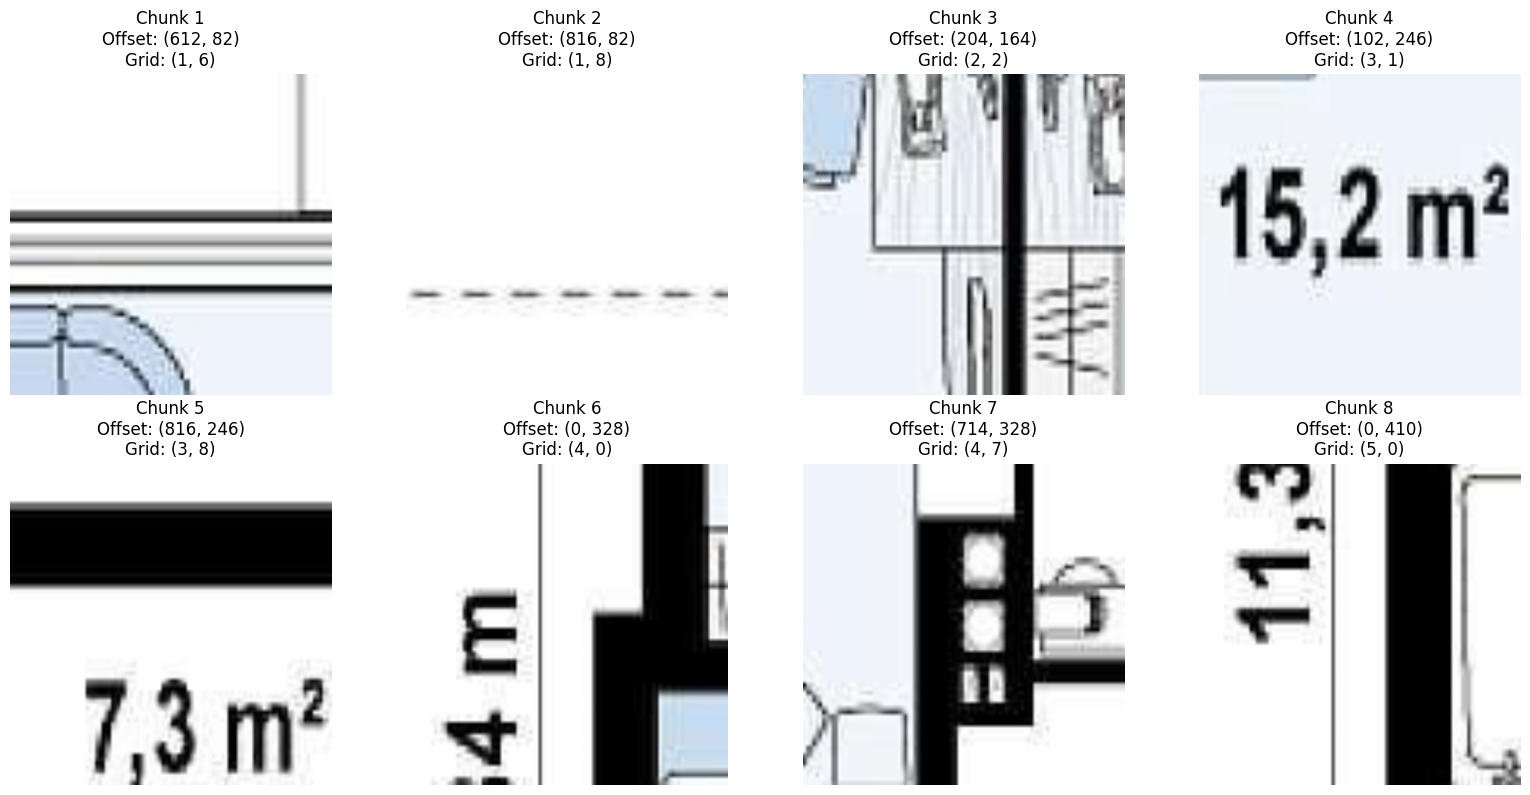

In [33]:
visualize_chunks(chunks, max_chunks=8, cols=4)
